In [ ]:
def load_data_from_drive(file_url, output_path):
    # Extract file ID from URL
    file_id = file_url.split("/d/")[1].split("/view")[0]

    # Construct download link
    download_url = f"https://drive.google.com/uc?id={file_id}"

    # Download file
    gdown.download(download_url, output_path, quiet=False)

# Load the data from my drive
import gdown
load_data_from_drive("https://drive.google.com/file/d/1IYVkJ16ZL1D-LKhPGzfl1eB2rjLKH4yC/view?usp=drive_link", "X_train_tabular.npy")
load_data_from_drive("https://drive.google.com/file/d/10uNMOfGVrgkAmgZdzbZ3DuBYmpqtYuW7/view?usp=drive_link", "y_train_tabular.npy")
load_data_from_drive("https://drive.google.com/file/d/1OBXuczL-OAg_OdME3HAzN9J3VdhqKGUm/view?usp=drive_link", "X_train_padding.npy")
load_data_from_drive("https://drive.google.com/file/d/107Qww9eGFVcu92P522bZimQhW0dSpbLs/view?usp=drive_link", "y_train_padding.npy")

Downloading...
From: https://drive.google.com/uc?id=1IYVkJ16ZL1D-LKhPGzfl1eB2rjLKH4yC
To: /content/X_train_tabular.npy
100%|██████████| 209M/209M [00:05<00:00, 37.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=10uNMOfGVrgkAmgZdzbZ3DuBYmpqtYuW7
To: /content/y_train_tabular.npy
100%|██████████| 489M/489M [00:07<00:00, 65.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1OBXuczL-OAg_OdME3HAzN9J3VdhqKGUm
To: /content/X_train_padding.npy
100%|██████████| 239M/239M [00:04<00:00, 58.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=107Qww9eGFVcu92P522bZimQhW0dSpbLs
To: /content/y_train_padding.npy
100%|██████████| 278M/278M [00:05<00:00, 52.6MB/s]


In [ ]:
import numpy as np

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Sequential Data

In [ ]:
# Motion, duration (seq_lenght), features ---> (203, 12246, 12)


In [ ]:
# Load your input and output data
x_train_padd = np.load("X_train_padding.npy")
y_train_padd = np.load("y_train_padding.npy")
print(x_train_padd.shape)
print(y_train_padd.shape)

(203, 12246, 12)
(203, 12246, 14)


In [ ]:
# Convert the data to PyTorch tensors
x_train = torch.tensor(x_train_padd).float()
y_train = torch.tensor(y_train_padd).float()

train_data = TensorDataset(x_train, y_train)

batch_size = 20
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
print(len(train_loader))

11


# Cnn and Lstm

In [ ]:
import torch
import torch.nn as nn

class DC_Model(nn.Module):
  #torch.Size([203, 12, 12246])
#
    def __init__(self):
        super(DC_Model, self).__init__()
        self.relu = nn.ReLU()
        #I want to discuss kernel size as by inc it seq_length decrease
        self.conv1 = nn.Conv1d(in_channels=12, out_channels=24, kernel_size=1, stride=1)
        self.conv2 = nn.Conv1d(in_channels=24, out_channels=48, kernel_size=1, stride=1)
        self.rnn = nn.LSTM(48, 24, batch_first=True)
        self.fc = nn.Linear(24, 14)


    def forward(self, input):

        # input shape: (batch_size, features, seq_length)

        x = self.relu(self.conv1(input))
        x = self.relu(self.conv2(x)) # will output [20,48,12446]
        x  =x.permute(0, 2, 1) #lstm should take [batch_size,seq_length,features] so i need to permute from [20,48,12446] ---> [20,12446,48]
        out, _ = self.rnn(x)
        out = self.fc(out)
        return out



device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Build and define your model
model = DC_Model()
model.to(device)



DC_Model(
  (relu): ReLU()
  (conv1): Conv1d(12, 24, kernel_size=(1,), stride=(1,))
  (conv2): Conv1d(24, 48, kernel_size=(1,), stride=(1,))
  (rnn): LSTM(48, 24, batch_first=True)
  (fc): Linear(in_features=24, out_features=14, bias=True)
)

In [ ]:
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

loss_values = []
epoch_count = []

# Train the model for 10 epochs
for epoch in range(10):
    train_loss = 0
    for x_train, y_train in train_loader:

        x_train, y_train = x_train.to('cuda'), y_train.to('cuda') # single batch
        x_train =x_train.permute(0, 2, 1)


        # Forward pass
        y_pred = model(x_train)

        # Zero the gradients
        optimizer.zero_grad()

        # Compute the loss
        loss = criterion(y_pred, y_train)
        train_loss += loss

        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()

    train_loss /= len(train_loader)

    # Print the loss
    print(f'Epoch: {epoch+1}, Loss: {train_loss:.4f}')
    loss_values.append(train_loss.cpu().detach().numpy())
    epoch_count.append(epoch)

Epoch: 1, Loss: 1706.1990
Epoch: 2, Loss: 1695.8685
Epoch: 3, Loss: 1706.7257
Epoch: 4, Loss: 1691.6105
Epoch: 5, Loss: 1706.0267
Epoch: 6, Loss: 1709.5684
Epoch: 7, Loss: 1622.7292
Epoch: 8, Loss: 1600.8486
Epoch: 9, Loss: 1558.5043
Epoch: 10, Loss: 1504.5374


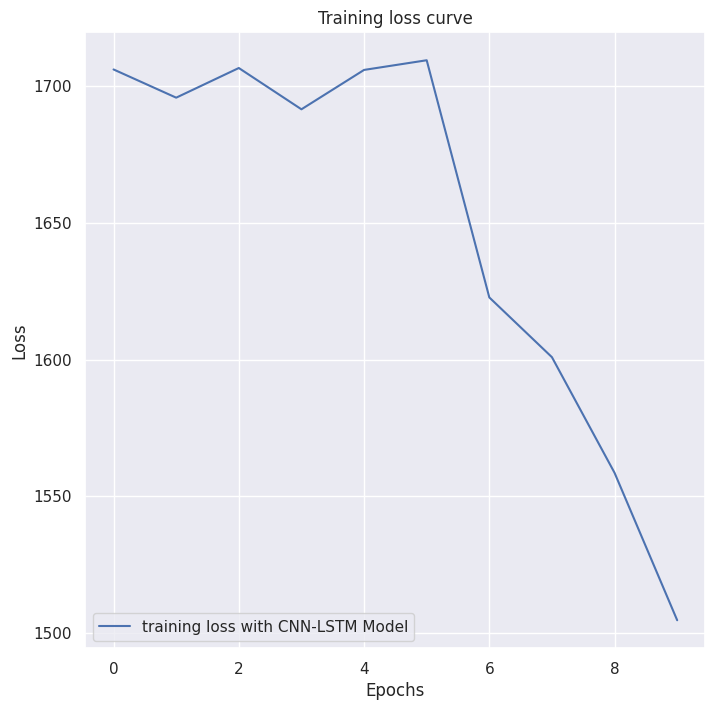

In [ ]:
plt.figure(figsize = (8, 8))
plt.plot(epoch_count, loss_values, label = "training loss with CNN-LSTM Model")

plt.title("Training loss curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.legend()
plt.show()

# Architecture I call it DC model


1.   Build Dnn
2.   Build Cnn
3.   Finally a linear layer




In [ ]:
# Convert the data to PyTorch tensors
x_train = torch.tensor(x_train).float()
y_train = torch.tensor(y_train).float()

train_data = TensorDataset(x_train, y_train)

batch_size = 100000
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
print(len(train_loader))

44


In [ ]:
class DC_Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.relu = nn.ReLU()

    self.drop = nn.Dropout(0.2)
    self.layer1 = nn.Linear(in_features=12,out_features=128)
    self.layer2 = nn.Linear(in_features=128 , out_features=256)
    self.layer3 = nn.Linear(in_features=256, out_features=512)
    self.layer4 = nn.Linear(in_features=512 , out_features=24)
    self.layer5 = nn.Linear(in_features=24 , out_features=12)

    self.conv1 =  nn.Conv1d(in_channels=1, out_channels=12, kernel_size=2, stride=1)
    self.elu =  nn.ELU()
    self.conv2 = nn.Conv1d(in_channels=12, out_channels=24, kernel_size=2, stride=1)
    self.flatt =  nn.Flatten()

    self.lin1 = nn.Linear(24*10,14)


  def forward(self,input):
    #input = (batch_size=10000, input_features=12)

    #DNN
    x = self.relu(self.layer1(input))
    x = self.relu(self.layer2(x))
    x = self.relu(self.layer3(x))
    x = self.drop(x)
    x = self.relu(self.layer4(x))
    x = self.relu(self.layer5(x))  #output_size = (batch_size=10000, output_features=12)
    x = x.unsqueeze(1)  #I need to change dim from 2D to 3D  ----------->[100000, 1, 12] pass it to cnn layer
    # CNN
    x = self.elu(self.conv1(x))
    x = self.elu(self.conv2(x)) # output of this layer 'll be (batch_size, out_channels , remaining_length ) ---->[100000,24,10]
    x = self.flatt(x) # After flattening inp to linear layer 'll be (24*10)
    # ANN
    x = self.lin1(x)
    x = self.elu(x)
    return x




device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Build and define your model
model = DC_Model()
model.to(device)


DC_Model(
  (relu): ReLU()
  (drop): Dropout(p=0.2, inplace=False)
  (layer1): Linear(in_features=12, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=256, bias=True)
  (layer3): Linear(in_features=256, out_features=512, bias=True)
  (layer4): Linear(in_features=512, out_features=24, bias=True)
  (layer5): Linear(in_features=24, out_features=12, bias=True)
  (conv1): Conv1d(1, 12, kernel_size=(2,), stride=(1,))
  (elu): ELU(alpha=1.0)
  (conv2): Conv1d(12, 24, kernel_size=(2,), stride=(1,))
  (flatt): Flatten(start_dim=1, end_dim=-1)
  (lin1): Linear(in_features=240, out_features=14, bias=True)
)

In [ ]:
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

loss_values = []
epoch_count = []

# Train the model for 10 epochs
for epoch in range(10):
    train_loss = 0
    for x_train, y_train in train_loader:

        x_train, y_train = x_train.to('cuda'), y_train.to('cuda') # single batch

        # Forward pass
        y_pred = model(x_train)

        # Zero the gradients
        optimizer.zero_grad()

        # Compute the loss
        loss = criterion(y_pred, y_train)
        train_loss += loss

        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()

    train_loss /= len(train_loader)

    # Print the loss
    print(f'Epoch: {epoch+1}, Loss: {train_loss:.4f}')
    loss_values.append(train_loss.cpu().detach().numpy())
    epoch_count.append(epoch)

Epoch: 1, Loss: 2273.3057
Epoch: 2, Loss: 379.0694
Epoch: 3, Loss: 320.0477
Epoch: 4, Loss: 319.4966
Epoch: 5, Loss: 319.5350
Epoch: 6, Loss: 319.5160
Epoch: 7, Loss: 319.4818
Epoch: 8, Loss: 319.4527
Epoch: 9, Loss: 319.4244
Epoch: 10, Loss: 319.4114


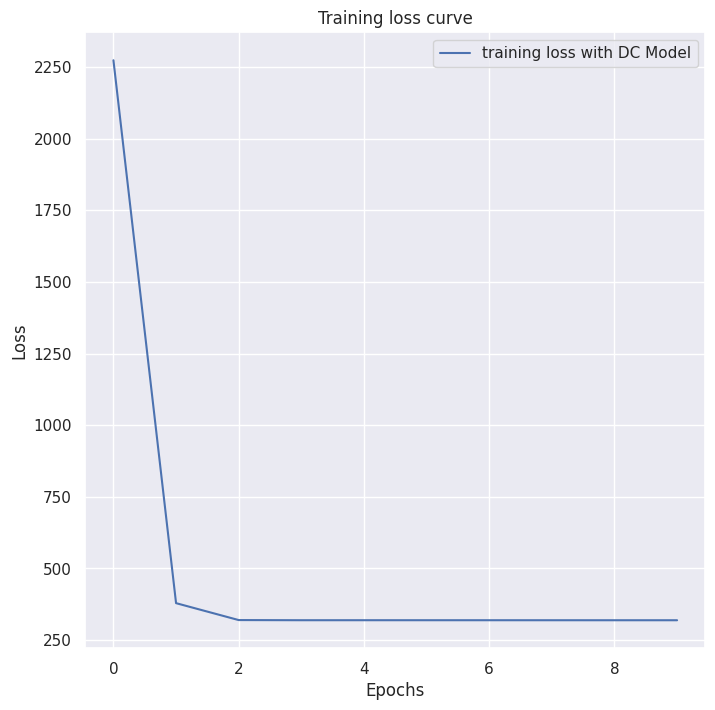

In [ ]:
plt.figure(figsize = (8, 8))
plt.plot(epoch_count, loss_values, label = "training loss with DC Model")

plt.title("Training loss curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.legend()
plt.show()